In [1]:
!pip install transformers'==4.2.2'

  Using cached transformers-4.2.2-py3-none-any.whl (1.8 MB)
  Using cached sacremoses-0.0.45-py3-none-any.whl (895 kB)
  Using cached tokenizers-0.9.4-cp37-cp37m-manylinux2010_x86_64.whl (2.9 MB)
  Using cached filelock-3.0.12-py3-none-any.whl (7.6 kB)


In [1]:
#!pip install seaborn

In [2]:
import torch
from transformers import (
    GPT2Tokenizer, GPT2LMHeadModel, TextDataset, LineByLineTextDataset,
    DataCollatorForLanguageModeling, TrainingArguments, Trainer, get_cosine_schedule_with_warmup
)

import matplotlib.pyplot as plt
%matplotlib inline

import json
import numpy as np
import seaborn as sns

import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
!nvidia-smi

Tue Apr 20 18:59:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.129      Driver Version: 410.129      CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:E5:00.0 Off |                    0 |
| N/A   45C    P0    85W / 350W |      0MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Подготовка обучающих данных



In [4]:
data_path = 'jokes.json'
with open(data_path, 'r') as f:
    data = json.loads(f.read())

Можно ввести дополнительные теги, которые после дообучения помогут модели понять, какой текст мы хотим от неё получить. Например, пусть каждая наша шутка будет начинаться с тега \<joke>, а заканчиваться -- тегом \<end> (в ruGPT-3 large не использовался тег \<|endoftext|> во время обучения)

In [5]:
processed = list()

for joke in data:
    pr_joke = '<joke> ' + joke + ' <end>'
    processed.append(pr_joke)

processed = ' '.join(processed)

In [7]:
train_data_path = 'jokes.txt'
with open(train_data_path, 'w') as t:
    t.write(processed)

Хорошая практика -- оценивать длину обучающих текстов, чтобы подобрать верные параметры предобработки. Мы уже знаем, что в нашем случае тексты имеют небольшой объём. И хотя стандартная токенизация, которую мы сейчас будем использовать, отличается от BPE-токенизации модели GPT, она все равно даст нам приблизительное представление.

/home/user/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

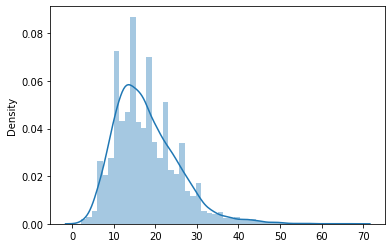

In [8]:
jokes_lengths = []

for joke in data:

    tokens = nltk.word_tokenize(joke, language="russian")
    jokes_lengths.append(len(tokens))

jokes_lengths = np.array(jokes_lengths)

sns.distplot(jokes_lengths)

In [9]:
np.average(jokes_lengths) 

17.7787

# Токенизация

Загружаем токенизатор ruGPT-3 из библиотеки transformers. При загрузке токенизатора можно указывать значения некоторых специальных токенов. Для чего это нужно? Для того, чтобы токенизатор не разделял каждый из введённых нами тегов на отдельные токены, а обрабатывал их как цельные.

In [10]:
bos_token = '<joke>'
eos_token = '<end>'

In [11]:
tokenizer = GPT2Tokenizer.from_pretrained("sberbank-ai/rugpt3large_based_on_gpt2", bos_token=bos_token, eos_token=eos_token, pad_token='<|pad|>')

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Свои кастомизированные специальные токены можно добавлять и таким способом:

In [ ]:
# special_tokens_dict = {'eos_token': '<end>', 'additional_special_tokens': ['<ask:love>']}
# tokenizer.add_special_tokens(special_tokens_dict)

In [12]:
print("У начального токена последовательности {} id имеет номер {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("У конечного токена последовательности {} id имеет номер {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))

У начального токена последовательности <joke> id имеет номер 50257
У конечного токена последовательности <end> id имеет номер 50258


Преобразовать данные для обучения можно с помощью TextDataset или LineByLineTextDataset: первый, получив на вход путь к файлу, читает данные полностью, токенизирует их и делит на блоки длины block_size; второй же каждую строку файла читает отдельно (то есть каждый текст должен начинаться с новой строки), токенизирует её и обрезает до длины block_size. Вы можете выбрать, какой из этих подходов лучше соответствует вашим данным.

In [13]:
block_size = 256

In [14]:
train_dataset = TextDataset(tokenizer=tokenizer, file_path=train_data_path, block_size=block_size, overwrite_cache=True)

/home/user/conda/lib/python3.7/site-packages/transformers/data/datasets/language_modeling.py:58: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/language-modeling/run_mlm.py
  FutureWarning,


In [ ]:
# train_dataset_lbl = LineByLineTextDataset(tokenizer=tokenizer, file_path=data_path, block_size=window_size)

# Дообучение модели ruGPT-3

Загружаем модель ruGPT-3 large. Это русскоязычная модель на основе архитектуры OpenAI, которая была разработана и обучена командами SberDevices, SberAI и SberCloud на более чем 600 Гб открытых данных википедии, художественной литературе, диалогах, программном коде.

In [15]:
model = GPT2LMHeadModel.from_pretrained("sberbank-ai/rugpt3large_based_on_gpt2")

В модели должно быть столько эмбеддингов, сколько токенов в токенизаторе -- так как мы добавили свои теги-токены, делаем resize_token_embeddings:

In [16]:
model.resize_token_embeddings(len(tokenizer))

Embedding(50260, 1536)

Задаём параметры обучения:

In [17]:
learning_rate = 2e-5
batch_size = 2
num_epochs = 4

Количество эпох не стоит делать большим (оптимально -- 3-5), иначе модель переобучится.

In [18]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

seed = 567
training_args = TrainingArguments(
    output_dir='jokes_output',
    overwrite_output_dir=True,
    do_train=True,
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    prediction_loss_only=True,
    logging_steps=100,
    load_best_model_at_end=True,
    #save_steps=300,
    seed=seed,
    learning_rate=learning_rate
)

Класс Trainer библиотеки transformers (для которого мы только что определили TrainingArguments) в большинстве случаев отлично подходит для организации цикла обучения и оценки качества (параметр evaluate): он прост и оптимизирован для работы с предобученными моделями transformers:

In [19]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

train_dataloader = trainer.get_train_dataloader()
num_train_steps = len(train_dataloader) * num_epochs
trainer.create_optimizer_and_scheduler(num_train_steps) #по дефолту в качестве оптимизатора используется AdamW;
                                                        #если вы хотите изменить оптимизатор и/или scheduler, 
                                                        #можно либо передать кортеж, содержащий оптимизатор и  
                                                        #scheduler в init класса Trainer через параметр optimizers,
                                                        #либо создать подкласс и переопределить этот метод в 
                                                        #подклассе
trainer.lr_scheduler = get_cosine_schedule_with_warmup(
    trainer.optimizer,
    num_warmup_steps=num_train_steps//10,
    num_training_steps=num_train_steps
)

Заводим!

In [20]:
trainer.train()

/home/user/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Step,Training Loss
100,4.408300
200,3.064000
300,3.034000
400,3.014200
500,2.992000
600,2.694400
700,2.680700
800,2.686300
900,2.676100
1000,2.693800


TrainOutput(global_step=1521, training_loss=2.813168454844257, metrics={'train_runtime': 482.5065, 'train_samples_per_second': 3.152, 'total_flos': 3549029070274560, 'epoch': 3.0})

# Сохраняем и загружаем дообученную модель

In [ ]:
output_dir = 'jokes_rugpt3'

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

In [ ]:
# Загружаем дообученную модель и словарь

# model = GPT2LMHeadModel.from_pretrained(output_dir)
# tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
# model.to(device)

# Генерация текста

При генерации текстов возможно варьировать следующие параметры:


* *temperature* — параметр сглаживания; чем выше, тем сильнее сглаживание вероятностного распределения токенов при предсказании
* *top_k* — техника сэмплирования: сортировка предсказаний каждого следующего слова по вероятностям и отсекание вариантов после k-го токена
* *top_p* — техника сэмплирования: сортировка предсказаний каждого следующего слова по вероятностям и отсекание вариантов, как только суммарная вероятность предыдущих токенов превысит p
* *max_length* — максимальная длина генерируемого текста
* *repetition_penalty* — «штрафование» слов, которые уже были сгенерированы или относятся к исходной фразе
* *num_return_sequences* - количество вариантов последовательностей, которые вернёт модель

В блоге Hugging Face есть отличная [статья](https://huggingface.co/blog/how-to-generate), в которой подробно объясняется суть многих параметров генерации.

В качестве "затравки" для нашей дообученной модели подаём тег \<joke>: модель выучила, что после него следует юмористический контент

In [43]:
def generate(prompt):

    model.eval()

    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    input_ids = input_ids.to('cuda') #переносим инпут на GPU, где находится наша модель

    eos_id = tokenizer.encode(eos_token)[0]

    sample_outputs = model.generate(
        input_ids, 
        max_length=120, 
        do_sample=True, 
        top_k=50,
        top_p=0.92, 
        temperature=0.75,
        eos_token_id=eos_id,
        num_return_sequences=3
        )
    for i, sample_output in enumerate(sample_outputs):
          print("{}: {}\n\n".format(i+1, tokenizer.decode(sample_output, skip_special_tokens=True)))

In [39]:
prompt = '<joke>'

generate(prompt)

Setting `pad_token_id` to `eos_token_id`:50258 for open-end generation.


1: 
 Вы можете быть добрым, отзывчивым и нежным человеком, но если вы не нажмете на "Нравится" в соц. сетях, то никто этого не увидит. 


2:  На работе как на войне. Вроде бы и есть люди, но как-то не по себе. 


3: 
 "Блин, я сегодня весь день ничего не ел" — это когда тебе уже все равно, что есть, а ты все равно ничего не ешь. 




In [42]:
generate(prompt)

Setting `pad_token_id` to `eos_token_id`:50258 for open-end generation.


1:   Если у девушки на ногах сорок первый размер, значит, она ещё не созрела для отношений. 


2:   Мы так долго ждали этого момента, что он наступил. 


3:   Я всегда завидовал людям, которые не знают, что значит "Не пиши левой рукой", и пишут правой. 




In [53]:
generate(prompt)

Setting `pad_token_id` to `eos_token_id`:50258 for open-end generation.


1:   Если вы не можете понять, как работает телевизор, попробуйте найти на нём кнопку «Хочу спать». 


2:   Пришла весна, а с ней и похмелье. 


3:   У меня в жизни было много всего плохого, но, пожалуй, самая большая ошибка в моей жизни произошла в тот день, когда я в первый раз пошел в универ. 


